<a href="https://colab.research.google.com/github/luke-stucky/spring2025/blob/main/LS_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import pickle

# Ensure all columns are displayed
pd.set_option('display.max_columns', None)

In [32]:
from google.colab import files

uploaded = files.upload()

Saving waze_dataset.csv to waze_dataset.csv


In [33]:
# Load dataset
df0 = pd.read_csv('/content/waze_dataset.csv')
df = df0.copy()

# Display dataset info
df.info()
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB
<class 'pandas.core

In [34]:
def create_features(df):
    """Creates additional features for the dataset."""
    df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
    df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']
    df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)
    df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']
    df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
    df['km_per_drive'] = df['driven_km_drives'] / df['drives']
    df['percent_of_drives_to_favorite'] = (
        df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']
    df['device2'] = np.where(df['device'] == 'Android', 0, 1)
    df['label2'] = np.where(df['label'] == 'churned', 1, 0)

    # Handle infinite values
    df.replace([np.inf, -np.inf], 0, inplace=True)

    return df

df = create_features(df)
df = df.dropna(subset=['label'])
df.drop(['ID'], axis=1, inplace=True)

<ipython-input-34-324c0671a57b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['ID'], axis=1, inplace=True)


In [35]:
def split_data(df):
    """Splits data into training, validation, and test sets."""
    X = df.drop(columns=['label', 'label2', 'device'])
    y = df['label2']
    X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

In [36]:
def train_model(model, params, X_train, y_train):
    """Trains a model using GridSearchCV."""
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    grid_search = GridSearchCV(model, params, scoring=scoring, cv=4, refit='recall')
    grid_search.fit(X_train, y_train)
    return grid_search

rf = RandomForestClassifier(random_state=42)
rf_params = {'max_depth': [None], 'max_features': [1.0], 'max_samples': [1.0],
             'min_samples_leaf': [2], 'min_samples_split': [2], 'n_estimators': [300]}
rf_cv = train_model(rf, rf_params, X_train, y_train)

xgb = XGBClassifier(objective='binary:logistic', random_state=42)
xgb_params = {'max_depth': [6, 12], 'min_child_weight': [3, 5], 'learning_rate': [0.01, 0.1], 'n_estimators': [300]}
xgb_cv = train_model(xgb, xgb_params, X_train, y_train)

In [37]:
def evaluate_model(model_name, model, X_val, y_val):
    """Evaluates the model on validation data."""
    preds = model.best_estimator_.predict(X_val)
    return pd.DataFrame({
        'model': [model_name],
        'precision': [precision_score(y_val, preds)],
        'recall': [recall_score(y_val, preds)],
        'F1': [f1_score(y_val, preds)],
        'accuracy': [accuracy_score(y_val, preds)]
    })

results = evaluate_model('RF cv', rf_cv, X_val, y_val)
results = pd.concat([results, evaluate_model('XGB cv', xgb_cv, X_val, y_val)], axis=0)

In [38]:
# Test set evaluation
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)
xgb_test_scores = evaluate_model('XGB test', xgb_cv, X_test, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

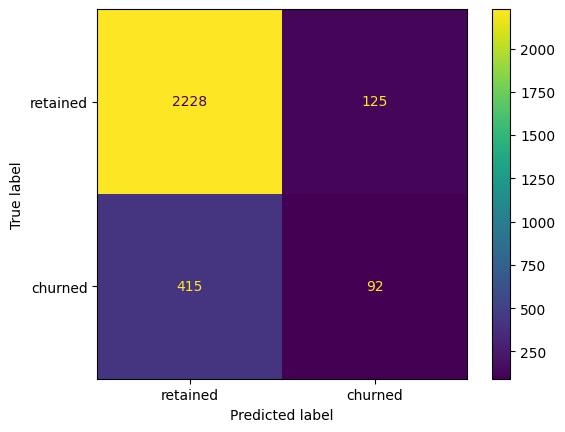

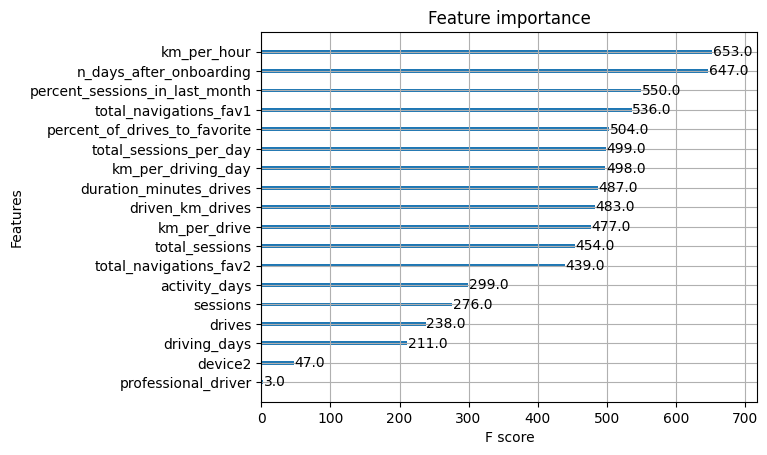

In [39]:
# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_test_preds), display_labels=['retained', 'churned'])
disp.plot()

# Feature Importance
plot_importance(xgb_cv.best_estimator_)

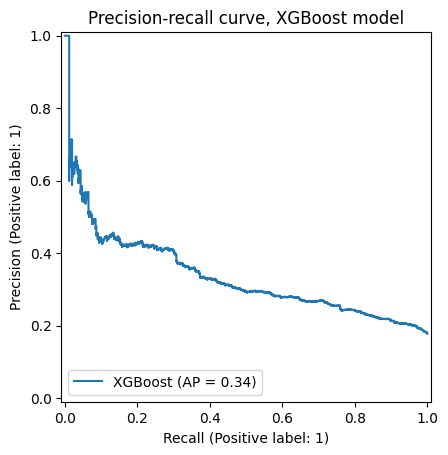

In [40]:
# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(xgb_cv.best_estimator_, X_test, y_test, name='XGBoost')
plt.title('Precision-recall curve, XGBoost model')
plt.show()

In [41]:
def threshold_finder(y_test, probabilities, desired_recall):
    """Finds the best decision threshold for the desired recall."""
    probs = probabilities[:, 1]
    thresholds = np.arange(0, 1, 0.001)
    scores = [(threshold, recall_score(y_test, np.where(probs >= threshold, 1, 0))) for threshold in thresholds]
    best_threshold, best_recall = min(scores, key=lambda x: abs(x[1] - desired_recall))
    return best_threshold, best_recall

# Find optimal threshold
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
thresh, _ = threshold_finder(y_test, probabilities, 0.5)
new_preds = np.where(probabilities[:, 1] >= thresh, 1, 0)
new_scores = evaluate_model(f'XGB threshold={thresh:.3f}', xgb_cv, X_test, y_test)
results = pd.concat([results, new_scores], axis=0)

In [42]:
display(results)

,model,precision,recall,F1,accuracy
0,RF cv,0.445255,0.120316,0.189441,0.817483
0,XGB cv,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189
0,XGB threshold=0.194,0.423963,0.181460,0.254144,0.811189
